In [1]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
from my_plotly_utils import *
import torch
import einops
from functools import partial
from jaxtyping import Float, Int, Bool
from typing import Tuple, Union, Optional, Callable, List
from torch import Tensor
import importlib

import model_settings
import plots
importlib.reload(model_settings)
importlib.reload(plots)
from model_settings import Model, Config, BasicMLP, optimize
from plots import *

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [113]:
config = Config(
    n_features = 5,
    n_hidden = 2,
    n_instances = 10,
)

importance = torch.ones(config.n_features)
importance[0] = 10
feature_probability = 0.03*torch.ones(config.n_instances)
model = BasicMLP(
    config=config,
    device=DEVICE,
    importance = importance[None, :],
    feature_probability = feature_probability[:, None]
)

optimize(model,
         steps=10_000,
         batch_fn=Model.generate_batch_rand,
         loss_fn=Model.mse_loss,
         lr=1e-3,
         )

# model.load_state_dict(torch.load('models/MSE_f5_h2_p03_imp101.pt'))
print('Importance:', model.importance)
print('Feature probability:', model.feature_probability.T)

  0%|          | 0/10000 [00:00<?, ?it/s]

Importance: Parameter containing:
tensor([[10.,  1.,  1.,  1.,  1.]], device='cuda:0')
Feature probability: tensor([[0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
         0.0300]], device='cuda:0')


In [114]:
model.requires_grad_(False)
model.W.data = model.W.data / model.W.data.norm(dim=-1, keepdim=True)
# new_W = torch.randn_like(model.W)
# new_W = new_W / torch.norm(new_W, dim=-1, keepdim=True)
# model.W.data = new_W
# model.b_final.data = 0.2*torch.rand_like(model.b_final)

In [4]:
def noise_error_fn(x: float, b: float, sigma: float):
    return norm.pdf(x, b, sigma) * (x ** 2)
    
def noise_error_fn_vec(x: Float[Tensor, 'a'], b: Union[float, Float[Tensor, 'b']], 
                       sigma: Union[float, Float[Tensor, 'b']]):
    assert x.ndim == 1
    assert type(b) is float or x.shape == b.shape
    if isinstance(sigma, float):
        return norm.pdf(x, b, sigma) * x ** 2
    else:
        assert sigma.ndim == 1
        return norm.pdf(x, b, sigma[:, None]) * x ** 2

def noise_incidence(b: float, sigma: float):
    if abs(sigma) < 1e-8:
        return 0
    out, _ = quad(partial(noise_error_fn, b=b, sigma=sigma), 0, np.inf)
    return out

def noise_incidence_vec(b: Union[float, Float[Tensor, '...']],
                        sigma: Union[float, Float[Tensor, 'sigma ...']]):
    return np.vectorize(noise_incidence)(b, sigma)

def estimate_noise_model(model: BasicMLP, noise_std: Union[float, Float[Tensor, 'noise']], feature_probability=None):
    noise_std = noise_std[:, None, None].cpu() if isinstance(noise_std, Tensor) else noise_std
    W = model.W.clone().detach().cpu() # [instances, features, hidden]
    b = model.b_final.clone().detach().cpu() # [instances, features]
    feature_norm = W.norm(dim=-1) # [instances, features]
    if feature_probability is None:
        feature_probability = model.feature_probability # [instances, features]
    feature_probability = feature_probability.cpu()
    noise_std_out = noise_std * feature_norm ** 2 # [instances, features]

    interference = torch.einsum('ifh,igh->ifg', W, W) # not excluding self-interference
    pos_interference_mask = (interference > 0).float() 
    pos_interference = interference * pos_interference_mask
    
    mean_pos_interference = pos_interference.sum(-1) / (2 * pos_interference_mask.sum(-1)) # [instances, features]
    interference_gap = b + mean_pos_interference # [instances, features]
    n_neighbors = pos_interference_mask.sum(-1) # [instances, features]
    feat_prob_neighbors = (feature_probability[:, None, :] * pos_interference_mask).sum(-1) / pos_interference_mask.sum(-1) # [instances, features]

    inactive_prob = (1 - feat_prob_neighbors) ** n_neighbors # [instances, features]
    interference_prob = n_neighbors*feature_probability # [instances, features]

    inactive_incidence = torch.from_numpy(noise_incidence_vec(b, noise_std_out)) # [instances, features] / [noise, instances, features]
    interference_incidence = torch.from_numpy(noise_incidence_vec(interference_gap, noise_std_out)) # [instances, features] / [noise, instances, features]

    inactive_loss = inactive_prob * inactive_incidence # [instances, features] / [noise, instances, features]
    interference_loss = interference_prob * interference_incidence # [instances, features] / [noise, instances, features]

    info_dict = {
        'feature_norm': feature_norm,
        'feature_probability': feature_probability,
        'mean_pos_interference': mean_pos_interference,
        'interference_gap': interference_gap,
        'n_neighbors': n_neighbors,
        'feat_prob_neighbors': feat_prob_neighbors,
        'inactive_prob': inactive_prob,
        'interference_prob': interference_prob,
        'inactive_incidence': inactive_incidence,
        'interference_incidence': interference_incidence,
        'inactive_loss': inactive_loss,
        'interference_loss': interference_loss, 
    }
    return info_dict
    

In [92]:
sigma = torch.logspace(np.log10(0.01), np.log10(5), 6)
b = torch.linspace(-1, 1, 20)

noise = torch.randn(10000, len(sigma), len(b)) * sigma[:, None]
out_emp = torch.relu(noise + b).pow(2).mean(0)
# out_emp = (torch.relu(noise - b).pow(2) - torch.relu(b).pow(2)).mean(0)
out_theo = torch.from_numpy(noise_incidence_vec(b, sigma[:, None]))

figs = []
for sigma_line_emp, sigma_line_theo in zip(out_emp, out_theo):
    figs.append(line([sigma_line_emp, sigma_line_theo], x=b, margin=0, return_fig=True))
    # figs.append(line(sigma_line_theo, x=b, margin=0, return_fig=True))
figs_to_subplots(figs, 2, 3, height=500, title='Empirics vs integral for y=ReLU(noise + b)^2', shared_xaxes=True,
                 subplot_titles=[f'noise std: {s:.2f}' for s in sigma], vertical_spacing=0.15, xaxis='b', yaxis='y')

In [118]:
noise_std = torch.logspace(np.log10(0.01), np.log10(3), 10).to(DEVICE)
# noise_std = [0.5]

def calculate_empirical_loss_prob(model, noise_std, batch_size=4096*5):
    W = model.W.detach()
    interference = torch.einsum('ifh,igh->ifg', W, W) # not excluding self-interference
    pos_interference_mask = (interference > 0) # [instances, features, features]

    batch, target = batch_together(model.generate_batch_rand, reps=len(noise_std), n_batch=4096*5) # [batch, noise, instances, features]
    active_features = (batch > 0) # [batch, instances, features]
    pos_interference_feat_inactive = (~(active_features[..., None, :] & pos_interference_mask)).all(-1).float() # [batch, noise, instances, features]
    pos_interference_feat_any_active = (active_features[..., None, :] & pos_interference_mask).any(-1).float() # [batch, noise, instances, features]

    out = model.run_with_noise(batch, noise_std)
    # out_noiseless = model(batch)
    loss_per_feature = model.mse_loss_unweighted(out, target, per_feature=True) # [batch, noise, instances, features]
    # loss_per_feature_noiseless = model.mse_loss_unweighted(out_noiseless, target, per_feature=True) # [batch, noise, instances, features]


    # inactive_loss = (loss_per_feature*pos_interference_feat_inactive.float()).mean(0) # [noise, instances, features]
    # interference_loss = (loss_per_feature*pos_interference_feat_any_active.float()).mean(0) # [noise, instances, features]
    inactive_incidence = (loss_per_feature*pos_interference_feat_inactive).sum(0) / pos_interference_feat_inactive.sum(0) # [noise, instances, features]
    interference_incidence = (loss_per_feature*pos_interference_feat_any_active).sum(0) / pos_interference_feat_any_active.sum(0) # [noise, instances, features]
    return inactive_incidence, interference_incidence
    # inactive_prob = pos_interference_feat_inactive.float().mean(0) # [noise, instances, features]
    # interference_prob = pos_interference_feat_any_active.float().mean(0) # [noise, instances, features]

    # return inactive_prob, interference_prob
    # out = model.run_with_noise(batch, noise_std)
    # loss_per_feature = model.mse_loss_unweighted(out, target, per_feature=True)
    # num_active_features = (batch > 0).sum(-1, keepdim=True).expand(batch.shape)
    # zero_active = (num_active_features == 0).float()

    # loss_zero_active = (loss_per_feature*zero_active).sum(0)/zero_active.sum(0)

rel_error = lambda x, y: (x-y)/(y+1e-6)
noise_idx = 0
# info = estimate_noise_model(model, noise_std)
# inactive_incidence, interference_incidence = calculate_empirical_loss_prob(model, noise_std, batch_size=4096*64)
# factor = inactive_incidence.cpu().mean(dim=[-2, -1], keepdim=True)/info['inactive_incidence'].mean(dim=[-2, -1], keepdim=True)
imshow(rel_error(info['inactive_incidence'], inactive_incidence.cpu()), facet_col=0, facet_col_wrap=5, 
       facet_labels=[f'Noise std: {s: .3f}' for s in noise_std], title='Relative error of inactive incidence theoretical prediction')
imshow(rel_error(info['interference_incidence'], interference_incidence.cpu()).clamp(max=1), facet_col=0, facet_col_wrap=5,
       facet_labels=[f'Noise std: {s: .3f}' for s in noise_std], title='Relative error of interference incidence theoretical prediction (clamped at 1)')

imshow(torch.stack([inactive_incidence.cpu(), info['inactive_incidence']]), facet_col=0, animation_frame=1)
# imshow(info['inactive_incidence'], animation_frame=0)
# imshow(torch.stack([inactive_incidence.cpu(), info['inactive_incidence']]), facet_col=0, animation_frame=1)
# imshow(torch.stack([interference_incidence.cpu(), info['interference_incidence']]), facet_col=0, animation_frame=1)
# imshow(torch.stack([interference_prob.cpu().squeeze(), info['interference_prob']]), facet_col=0,
#        facet_labels=['Theoretical Model', 'Empirical Model'], title='Interference Probability', yaxis_title='Instance', xaxis_title='Feature')
# imshow(torch.stack([inactive_prob.cpu().squeeze(), info['inactive_prob']]), facet_col=0, color_continuous_midpoint=None,
#        facet_labels=['Theoretical Model', 'Empirical Model'], title='Inactive Probability', yaxis_title='Instance', xaxis_title='Feature')

In [63]:
# info = estimate_noise_model(model, noise_std=0.1)
# bar(info['neg_b'].T, barmode='group')
# bar(info['mean_pos_interference'].T, barmode='group')
# bar(info['n_neighbors'].T, barmode='group')
# bar(info['feat_prob_neighbors'].T, barmode='group')
# bar(info['inactive_prob'].T, barmode='group')
# bar(info['inactive_loss'].T, barmode='group')
# bar(info['interference_prob'].T, barmode='group')
# bar(info['interference_loss'].T, barmode='group')
# imshow(info['inactive_loss'].log(), facet_col=0)

In [99]:
b = model.b_final.detach()
line([b_i for b_i in b])

[('Feat 0', 'b'), ('Feat 1', 'r'), ('Feat 2', 'g'), ('Feat 3', 'm'), ('Feat 4', 'darkorange')]


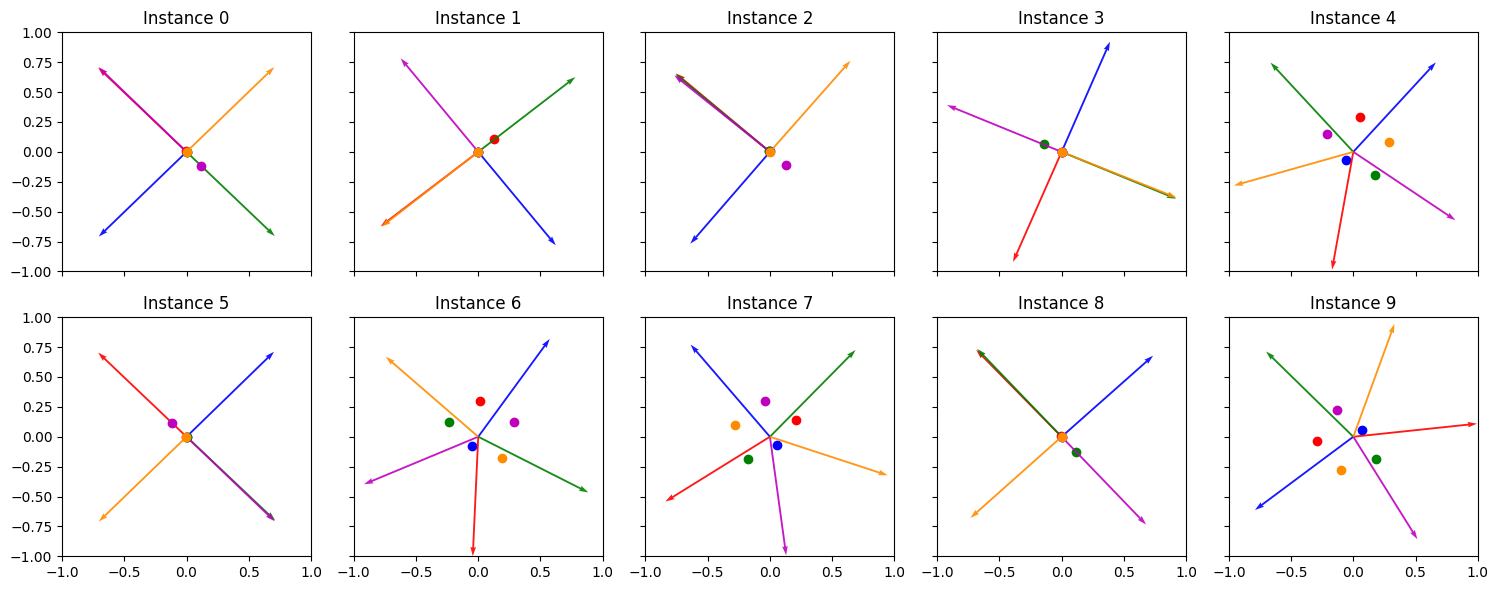

In [115]:
plot_hidden_2D(model)

In [17]:
b[9]

0.0

In [64]:
b = -.1
noise_std = np.logspace(np.log10(0.01), np.log10(0.5), 3)
x = np.linspace(-1, 3, 1000)
noise_fn_values = noise_error_fn_vec(x, b, noise_std[:])
fig1 = line([x for x in noise_fn_values], x=x, return_fig=True)

b = .1
noise_fn_values = noise_error_fn_vec(x, b, noise_std[:])
fig2 = line([x for x in noise_fn_values], x=x, return_fig=True)

figs_to_subplots([fig1, fig2], 1, 2, shared_xaxes=True, shared_yaxes=True,
                 subplot_titles=['Bias = -0.1', 'Bias = 0.1'], title='Noise Error function for different biases and noise std')

In [37]:
b = np.linspace(-.2, .1, 10)
noise_std = torch.logspace(np.log10(0.01), np.log10(0.5), 10)
noise_inc_values = noise_incidence_vec(b, noise_std[:, None])
# noise_inc_values = noise_inc_values / noise_inc_values[:, [9]]
    # noise_fn_values = noise_error_fn_vec()
# line([x for x in noise_inc_values], x=b)
line([x for x in noise_inc_values.T], x=noise_std, names=[f'Bias={b_i:.2f}' for b_i in b],
     labels=dict(x='Noise std', value='Noise incidence'), title='Noise incidence as a function of noise std')
    # line(noise_inc_values, x=b_values, labels=dict(x='Lower integration limit', value='Expected noise incidence'),
    #     title='Expected noise incidence as a function of b', names=[f'sigma={sigma}' for sigma in sigma_values])
    # line(noise_fn_values, x=b_values, labels=dict(value='Noise density'), title='Derivative of the noise incidence x^2 * f(x)',
    #     names=[f'sigma={sigma}' for sigma in sigma_values])

In [33]:
b = np.linspace(0, 1, 10)
noise_std = torch.logspace(np.log10(0.01), np.log10(1), 10)
noise_inc_values = noise_incidence_vec(b, noise_std[:, None])
noise_inc_values = noise_inc_values / noise_inc_values[:, [0]]
line([x for x in noise_inc_values.T], log_y=True)